In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from patsy import dmatrices, dmatrix


from PIL import Image
import requests
from io import BytesIO
import urllib3
urllib3.disable_warnings()


In [14]:
df = pd.read_csv("Auto.csv")
df = df.replace('?', None)
df = df.ffill()
df['origin'] = df.origin.astype('category')
df['horsepower'] = df.horsepower.astype('int64')

In [3]:
y, X = dmatrices('mpg ~ horsepower ', data=df, return_type='dataframe') 
model = sm.OLS(df.mpg, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     605.1
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           1.08e-81
Time:                        23:00:34   Log-Likelihood:                -1195.2
No. Observations:                 397   AIC:                             2394.
Df Residuals:                     395   BIC:                             2402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.0619      0.717     55.905      0.000      38.653      41.471
horsepower    -0.1588      0.006    -24.599      0.000      -0.171      -0.146
==============================================================================
Omnibus:                       16.560   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.444
Skew:                           0.494   Prob(JB):                     0.000163
Kurtosis:                       3.278   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

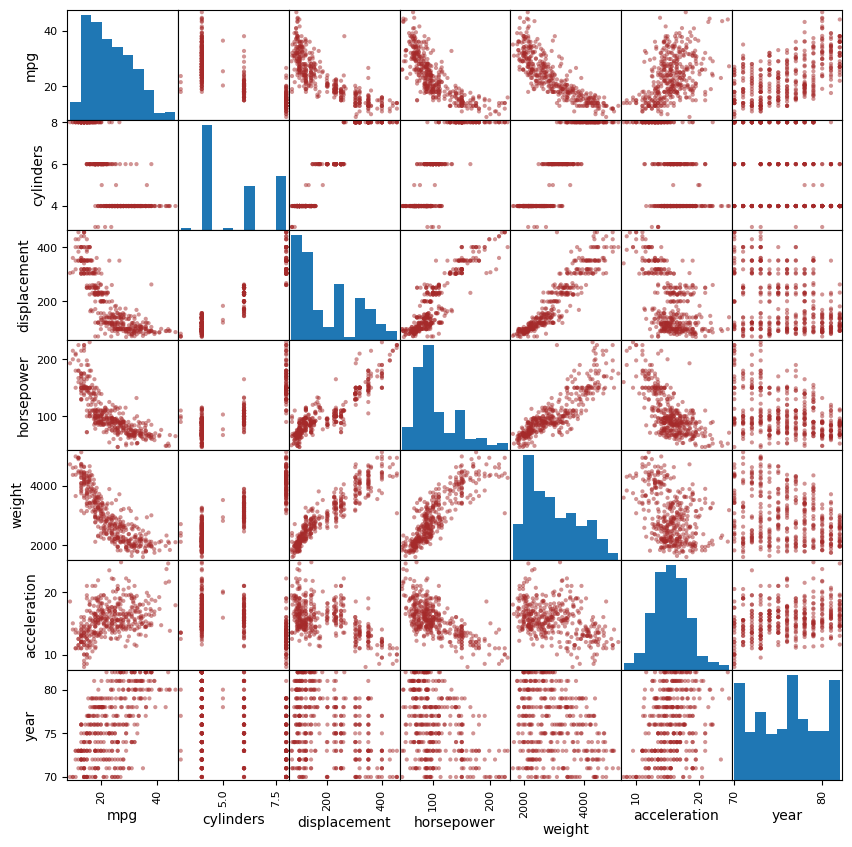

In [4]:
_ = pd.plotting.scatter_matrix(df, color="brown",figsize=(10,10),)

In [5]:
df[df.columns.difference(['name'])].corr()

,acceleration,cylinders,displacement,horsepower,mpg,origin,weight,year
acceleration,1.000000,-0.504061,-0.544162,-0.687768,0.422297,0.210084,-0.419502,0.282901
cylinders,-0.504061,1.000000,0.950920,0.842826,-0.776260,-0.564972,0.897017,-0.346717
displacement,-0.544162,0.950920,1.000000,0.897168,-0.804443,-0.610664,0.933104,-0.369804
horsepower,-0.687768,0.842826,0.897168,1.000000,-0.777842,-0.453590,0.864218,-0.417440
mpg,0.422297,-0.776260,-0.804443,-0.777842,1.000000,0.563698,-0.831739,0.581469
origin,0.210084,-0.564972,-0.610664,-0.453590,0.563698,1.000000,-0.581265,0.184314
weight,-0.419502,0.897017,0.933104,0.864218,-0.831739,-0.581265,1.000000,-0.307900
year,0.282901,-0.346717,-0.369804,-0.417440,0.581469,0.184314,-0.307900,1.000000


In [6]:
def lineReg(formula, dataFrame):
    mask = np.random.rand(len(df)) < 0.8
    train = df[mask]
    valid = df[~mask]

    y_train, X_train = dmatrices(formula, data=train, return_type='dataframe')   
    y_valid, X_valid = dmatrices(formula, data=valid, return_type='dataframe')

    # sklearn output, set  C = 1e9 to avoid regularization
    model = sm.OLS(y_train, X_train)
    result = model.fit()

    return result

In [15]:
dfNoNames = df[df.columns.difference(['name'])]

formulas = [
    'mpg ~ cylinders',
    'mpg ~ displacement',
    'mpg ~ horsepower',
    'mpg ~ weight',
    'mpg ~ acceleration',
    'mpg ~ year',
    'mpg ~ origin',
    'mpg ~ I(np.log(cylinders))',
    'mpg ~ I(np.log(displacement))',
    'mpg ~ I(np.log(horsepower))',
    'mpg ~ I(np.log(weight))',
    'mpg ~ I(np.log(acceleration))',
    'mpg ~ I(np.sqrt(cylinders))',
    'mpg ~ I(np.sqrt(displacement))',
    'mpg ~ I(np.sqrt(weight))',
    'mpg ~ I(np.sqrt(acceleration))',
    'mpg ~ I(np.sqrt(cylinders)) + (weight ** 2) * acceleration',
    'mpg ~ horsepower + weight + acceleration',
    'mpg ~ horsepower * year + origin',
    'mpg ~ horsepower : displacement',
    'mpg ~ origin + year : weight \n + I(np.sqrt(displacement)) : cylinders ** 2',
    'mpg ~ (origin + year : I(np.sqrt(horsepower)))  \n * I(np.log(cylinders)) * acceleration ** 2',
]

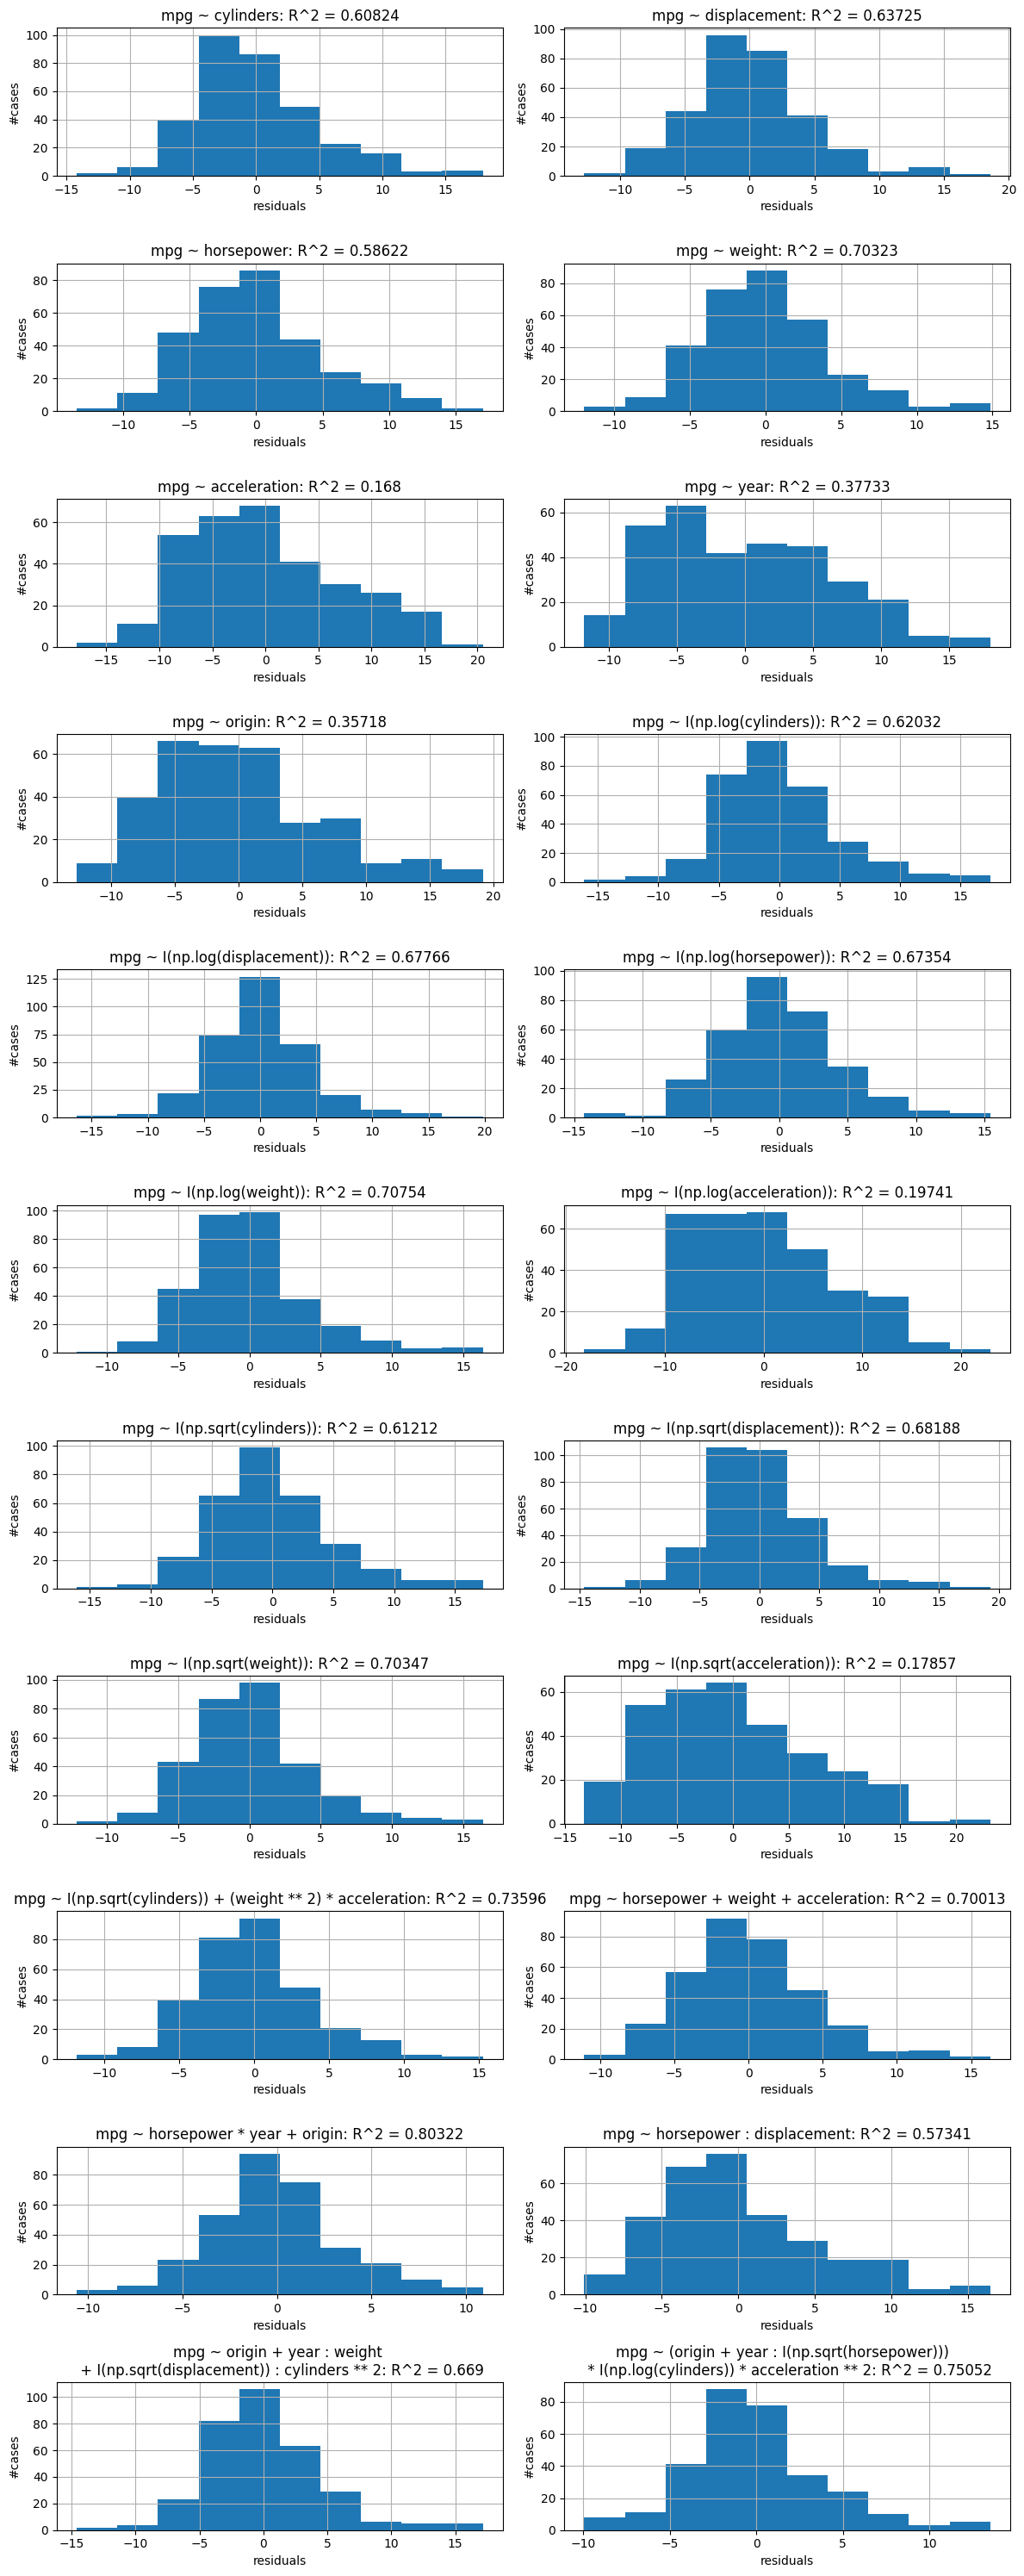

In [16]:
fig = plt.figure(figsize=(12, 30))
res = []
for i, formula in enumerate(formulas):
    fig.add_subplot(11, 2, i+1)
    resI = lineReg(formula, df)
    ax = resI.resid.hist()
    ax.set_xlabel("residuals")
    ax.set_ylabel("#cases")
    ax.set_title(f'{formula}: R^2 = {round(resI.rsquared, 5)}')
    plt.tight_layout()
    res.append((formula, resI.rsquared))

In [17]:
print(f"Best -> {max(res, key = lambda item: item[1])}")
print(f"Worst -> {min(res, key = lambda item: item[1])}")

Best -> ('mpg ~ horsepower * year + origin', 0.8032238232907241)
Worst -> ('mpg ~ acceleration', 0.16800477498149413)


In [58]:
def removeOutliersAndHighLevereage(model, df):
    inf = model.get_influence()
    resid = model.resid_pearson
    leverage = inf.hat_matrix_diag
    leverageCutoff = (2 * (len(model.params)) + 2) / len(df.index)
    print(leverageCutoff)
    indexToFilter = []
                      
    for i in range(len(resid)):
        if abs(resid[i]) > 2 or leverage[i] > 0.04:
            indexToFilter.append(i)
                      
    return df[~df.index.isin(indexToFilter)]

In [59]:
df = pd.read_csv("Auto.csv")
df = df.replace('?', None)
df = df.ffill()
df['origin'] = df.origin.astype('category')
df['horsepower'] = df.horsepower.astype('int64')

0.03526448362720403


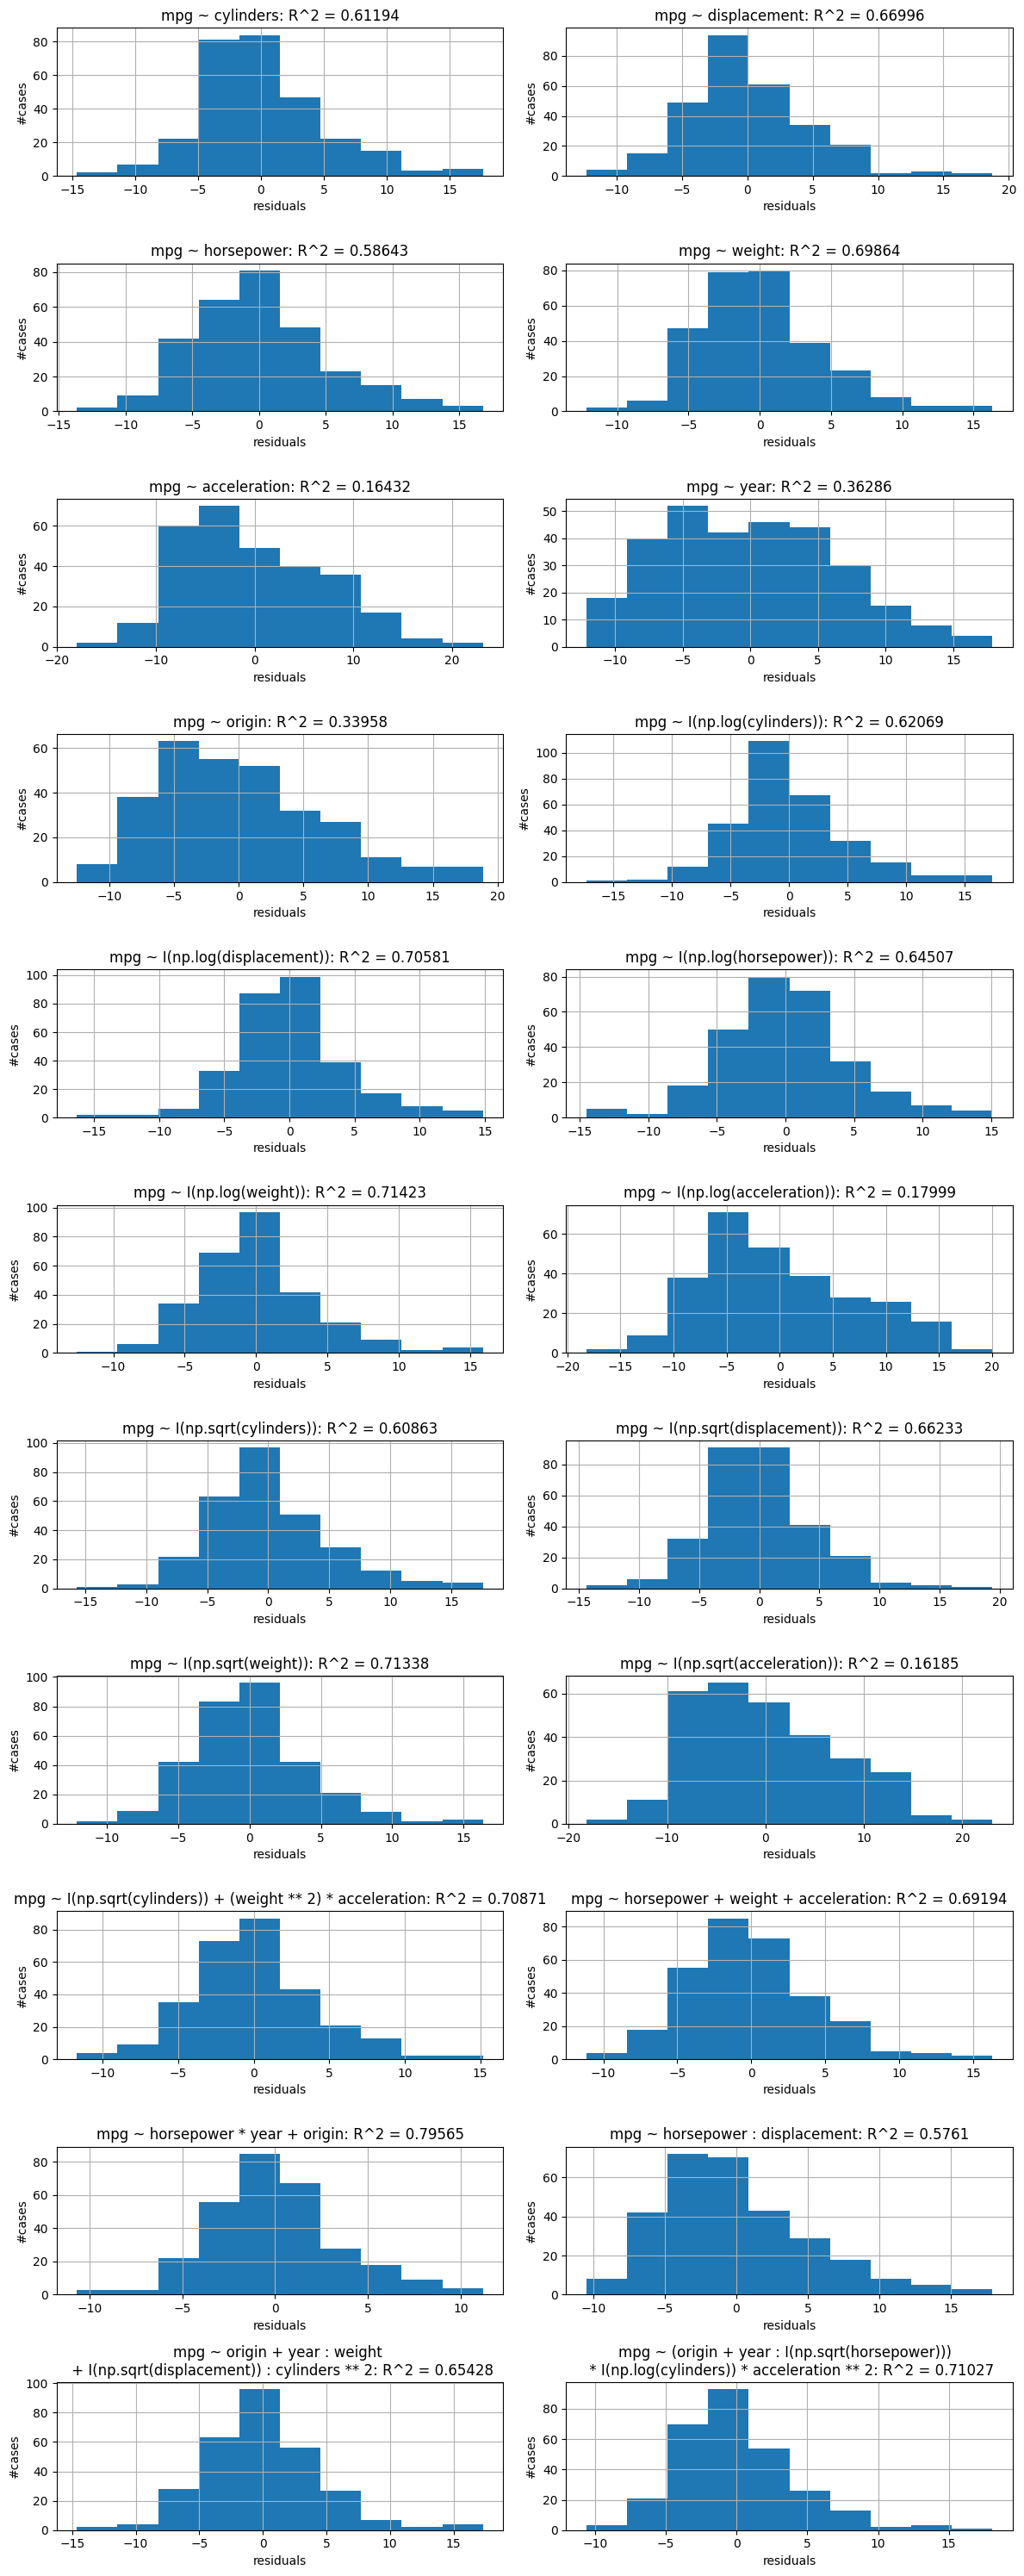

In [60]:
df = removeOutliersAndHighLevereage(lineReg(formulas[-4], df), df)

fig = plt.figure(figsize=(12, 30))
res = []
for i, formula in enumerate(formulas):
    fig.add_subplot(11, 2, i+1)
    resI = lineReg(formula, df)
    ax = resI.resid.hist()
    ax.set_xlabel("residuals")
    ax.set_ylabel("#cases")
    ax.set_title(f'{formula}: R^2 = {round(resI.rsquared, 5)}')
    plt.tight_layout()
    res.append((formula, resI.rsquared))

In [61]:
print(f"Best -> {max(res, key = lambda item: item[1])}")
print(f"Worst -> {min(res, key = lambda item: item[1])}")

Best -> ('mpg ~ horsepower * year + origin', 0.7956547525971702)
Worst -> ('mpg ~ I(np.sqrt(acceleration))', 0.16184595930816137)
